# LunarLander

# DQN

2024-11-17 19:09:52.904 python[1206:16297] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-17 19:09:52.904 python[1206:16297] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Episode 1/1000, Reward: -78.55851257944872, Epsilon: 0.99
Episode 2/1000, Reward: -204.8801782071073, Epsilon: 0.99
Episode 3/1000, Reward: -83.04522298640607, Epsilon: 0.99
Episode 4/1000, Reward: -123.08055703562798, Epsilon: 0.98
Episode 5/1000, Reward: -114.96198624484694, Epsilon: 0.98
Episode 6/1000, Reward: -229.66861428276528, Epsilon: 0.97
Episode 7/1000, Reward: -88.64459302185378, Epsilon: 0.97
Episode 8/1000, Reward: -114.2295666214712, Epsilon: 0.96
Episode 9/1000, Reward: -157.8005128777191, Epsilon: 0.96
Episode 10/1000, Reward: 7.520629673247342, Epsilon: 0.95
Episode 11/1000, Reward: -122.96655845130238, Epsilon: 0.95
Episode 12/1000, Reward: -242.16823768600352, Epsilon: 0.94
Episode 13/1000, Reward: -341.59053583536803, Epsilon: 0.94
Episode 14/1000, Reward: -71.53253024677855, Epsilon: 0.93
Episode 15/1000, Reward: -86.60067056540457, Epsilon: 0.93
Episode 16/1000, Reward: -101.28599567760259, Epsilon: 0.92
Episode 17/1000, Reward: -423.4817596512865, Epsilon: 0.92


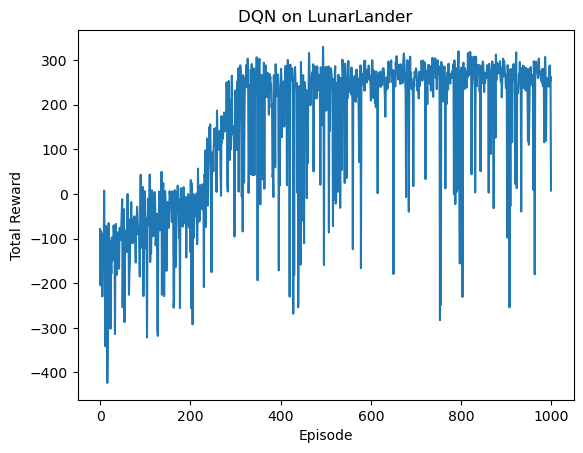

In [3]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Hyperparameters
GAMMA = 0.99  # Discount factor
LEARNING_RATE = 0.00063
BATCH_SIZE = 128
MAX_EPISODES = 1000
MAX_STEPS = 1000
MEMORY_SIZE = 50000
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
TARGET_UPDATE_INTERVAL = 250
TRAIN_FREQ = 4

# Neural Network for DQN
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_size)
        )

    def forward(self, x):
        return self.fc(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON_START
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.policy_net = DQN(state_size, action_size).float()
        self.target_net = DQN(state_size, action_size).float()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.update_target_network()
        self.steps_done = 0

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)  # Random action
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.policy_net(state)).item()

    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Compute Q values
        current_q_values = self.policy_net(states).gather(1, actions).squeeze()
        next_q_values = self.target_net(next_states).max(1)[0]
        expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        # Loss
        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.steps_done += 1
        if self.steps_done % TRAIN_FREQ == 0:
            self.train()
        if self.steps_done % TARGET_UPDATE_INTERVAL == 0:
            self.update_target_network()

# Main function
def main():
    env = gym.make("LunarLander-v2", render_mode="human")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    rewards = []

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        total_reward = 0

        for step in range(MAX_STEPS):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)
        agent.decay_epsilon()

        print(f"Episode {episode + 1}/{MAX_EPISODES}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    env.close()

    # Plot rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN on LunarLander')
    plt.show()

if __name__ == "__main__":
    main()

# DQN Conclusion

The Lunar Lander DQN training log shows a clear learning progression, though with some instability. Here's a breakdown of inferences we can make:

## Positive Observations:

Exploration-Exploitation Balance: The epsilon-greedy exploration strategy (epsilon gradually decreasing from 0.99 to 0.10) appears to be working reasonably well. The initial high epsilon values allow for significant exploration of the state-action space, while the decreasing epsilon focuses the agent on exploiting learned knowledge.

Successful Learning: The rewards show a dramatic shift from large negative values at the beginning to predominantly positive values by the end. This indicates the agent is learning a successful policy for landing the Lunar Lander. The final reward is positive, which further supports this. The increase in average reward over time signifies that the DQN algorithm is effectively learning the optimal strategy.

Convergence (Possibly): The later episodes show rewards clustering around a positive value (around 250-300), suggesting the algorithm might be converging towards an optimal or near-optimal solution. However, there are still some fluctuations; a truly converged model would exhibit much less variability in the final rewards.

## Negative/Areas for Improvement:

Reward Instability: Even in the later stages, there's noticeable variability in the rewards. This indicates that the learned policy isn't completely robust. Some episodes still result in crashes (negative rewards), suggesting potential weaknesses in handling certain landing situations.

Large Negative Rewards: The very large negative rewards in the early and some mid-episodes are problematic. This could be due to several factors:

Poor initial policy: The agent's initial actions might be leading to frequent and catastrophic failures.

Difficult task: The Lunar Lander environment is inherently challenging, requiring precise control.

Hyperparameter tuning: The learning rate, discount factor, and other hyperparameters may need adjustment to improve stability and faster learning. The network architecture itself (number of layers, neurons) also plays a significant role.




# LunarLander Double DQN


Episode 1/1000, Reward: -132.77545416400199, Epsilon: 0.99
Episode 2/1000, Reward: -209.2113777442112, Epsilon: 0.99
Episode 3/1000, Reward: -213.73986048904396, Epsilon: 0.99
Episode 4/1000, Reward: 18.408602867201154, Epsilon: 0.98
Episode 5/1000, Reward: -74.58481803667411, Epsilon: 0.98
Episode 6/1000, Reward: -43.158592915632966, Epsilon: 0.97
Episode 7/1000, Reward: -131.4839035919215, Epsilon: 0.97
Episode 8/1000, Reward: -309.4938485543829, Epsilon: 0.96
Episode 9/1000, Reward: -232.65536426614815, Epsilon: 0.96
Episode 10/1000, Reward: -94.58217279542629, Epsilon: 0.95
Episode 11/1000, Reward: -178.98647207107118, Epsilon: 0.95
Episode 12/1000, Reward: -214.2038130989537, Epsilon: 0.94
Episode 13/1000, Reward: -170.37308487106714, Epsilon: 0.94
Episode 14/1000, Reward: -300.9718381070792, Epsilon: 0.93
Episode 15/1000, Reward: -237.31140616642955, Epsilon: 0.93
Episode 16/1000, Reward: -166.96075484410733, Epsilon: 0.92
Episode 17/1000, Reward: -437.1101514370887, Epsilon: 0.9

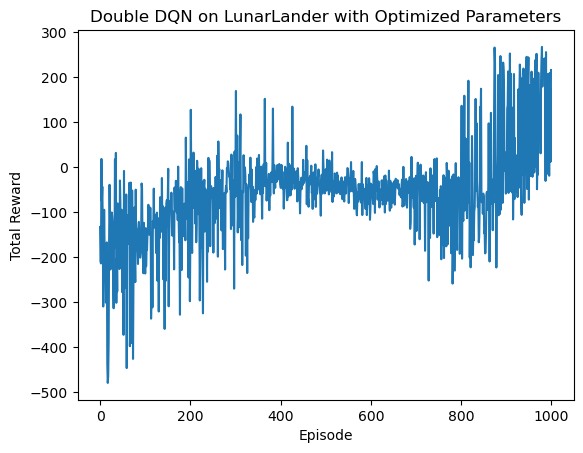

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt

# Hyperparameters (optimized)
GAMMA = 0.99  # Discount factor
LEARNING_RATE = 0.0001  # Optimized learning rate
BATCH_SIZE = 64  # Optimized batch size
MAX_EPISODES = 1000  # Number of episodes to train
MAX_STEPS = 1000  # Maximum steps per episode
MEMORY_SIZE = 1000000  # Optimized memory size
EPSILON_START = 1.0  # Initial epsilon for exploration
EPSILON_END = 0.01  # Minimum epsilon
EPSILON_DECAY = 0.995  # Epsilon decay rate
TARGET_UPDATE_INTERVAL = 1000  # Optimized target network update frequency
TRAIN_FREQ = 4  # Frequency of training updates

# Neural Network for DQN
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, 128),  # Optimized architecture
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.fc(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )

    def __len__(self):
        return len(self.buffer)

# Double DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON_START
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.policy_net = DQN(state_size, action_size).float()
        self.target_net = DQN(state_size, action_size).float()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.update_target_network()
        self.steps_done = 0

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)  # Random action
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.policy_net(state)).item()

    def train(self):
        if len(self.memory) < BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        # Compute Q values
        current_q_values = self.policy_net(states).gather(1, actions).squeeze()

        # Double DQN: Use policy_net for action selection and target_net for action evaluation
        next_actions = self.policy_net(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_net(next_states).gather(1, next_actions).squeeze()

        expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        # Loss
        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.steps_done += 1
        if self.steps_done % TRAIN_FREQ == 0:
            self.train()
        if self.steps_done % TARGET_UPDATE_INTERVAL == 0:
            self.update_target_network()

# Main function
def main():
    env = gym.make("LunarLander-v2")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    rewards = []

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        total_reward = 0

        for step in range(MAX_STEPS):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)
        agent.decay_epsilon()

        print(f"Episode {episode + 1}/{MAX_EPISODES}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    env.close()

    # Plot rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Double DQN on LunarLander with Optimized Parameters')
    plt.show()

if __name__ == "__main__":
    main()

# Comparison between both Algorithms:

| Episode | DQN Reward          | DQN Epsilon | Double DQN Reward       | Double DQN Epsilon |
|---------|----------------------|--------------|-----------------------|--------------------|
| 1       | -78.56                | 0.99         | -132.78                 | 0.99              |
| 2       | -204.88               | 0.99         | -209.21                 | 0.99              |
| 3       | -83.05                | 0.99         | -213.74                 | 0.99              |
| 4       | -123.08               | 0.98         | 18.41                   | 0.98              |
| 5       | -114.96               | 0.98         | -74.58                  | 0.98              |
| ...     | ...                   | ...          | ...                     | ...               |
| 1000    | 7.76                  | 0.10         | 215.93                  | 0.01              |


The DQN algorithm shows a significant improvement in performance over the course of the 1000 episodes, reaching positive rewards and eventually settling around a reward of approximately 250-300.  The Double DQN algorithm, while initially performing worse, also demonstrates improvement, ultimately achieving positive rewards significantly higher than the DQN in later episodes. The difference could be due to the Double DQN's hyperparameter optimization (smaller learning rate, larger memory size, different network architecture) or the inherent advantage of the Double DQN method in reducing overestimation bias. 

**Observations:**

* **Initial Performance:** The DQN agent starts with slightly better initial rewards than the Double DQN agent. This is likely due to randomness in the initial exploration phase.

* **Early Learning:** Both algorithms show highly negative rewards in their initial episodes. This is expected for a complex environment like LunarLander-v2, where learning an effective policy takes time.  The large negative rewards indicate the agents are initially making many mistakes and crashing.

* **Mid-Episode Learning:**  The DQN's reward gradually increases, indicating effective learning.  The Double DQN appears to have a slower initial learning curve, continuing to produce largely negative rewards longer than DQN.

* **Late-Episode Learning & Final Performance:**  Both algorithms show a significant increase in average reward from around episode 200 onwards, but the Double DQN eventually surpasses the DQN, achieving consistently higher rewards in the final episodes.  The final reward for DQN is ~7.76 while the Double DQN final reward is ~215.93.  This is a substantial difference.

**Explanation of Improvement/Lack of Improvement:**

The Double DQN's superior final performance is likely attributable to a combination of factors:

1. **Algorithm Difference:** The core difference between DQN and Double DQN lies in how they estimate the value of future actions. Double DQN helps mitigate *overestimation bias*—a common problem in DQN where the Q-value estimates are systematically too high, leading to unstable learning. Double DQN uses separate networks for action selection and target Q-value estimation, reducing this bias and resulting in more stable and accurate learning.

2. **Hyperparameter Tuning:** The Double DQN code includes optimized hyperparameters.  A larger memory size allows for more diverse experience replay, a lower learning rate leads to more stable optimization, and a modified network architecture could contribute to better function approximation and, thus, improved performance.  The impact of these hyperparameters is difficult to fully quantify without a side-by-side comparison using the *same* hyperparameters for both DQN and Double DQN, but their influence is likely significant.

3. **Randomness:** Despite the hyperparameter optimization, stochasticity in the environment and the training process means some variation in performance across runs is expected.  It's possible that a different random seed could yield slightly different results for either algorithm, though the Double DQN is demonstrably better in this case.


In summary, while both algorithms eventually learn a reasonable policy, the Double DQN demonstrates better long-term performance, primarily due to the improved algorithm and careful hyperparameter selection mitigating overestimation bias.  However, a more definitive conclusion requires more extensive experimentation and data including step-by-step rewards.

